# Forward Modelling of a Many Lines Spectrum using PreMODIT

Here, we try to compute a emission spectrum using PreMODIT.
Note that PreMODIT is a beta release. Presumably, we will improve it and release better one in ExoJAX 2.

In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

In [2]:
from exojax.spec import rtransfer as rt
from exojax.spec import premodit
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
#ATMOSPHERE                                                                     
NP=100
T0=1295.0 #K
Parr, dParr, k=rt.pressure_layer(NP=NP)
Tarr = T0*(Parr)**0.1

We set a wavenumber grid using wavenumber_grid. Specify xsmode="dit" though it is not mandatory.
DIT uses FFT, so the (internal) wavenumber grid should be linear. 
But, you can also use a nonlinear grid. In this case, the interpolation (jnp.interp) is used.   

In [4]:
from exojax.utils.grids import wavenumber_grid
nus,wav,R=wavenumber_grid(22900,23000,10000,unit="AA",xsmode="premodit")

xsmode assumes ESLOG in wavenumber space: mode=premodit


Loading a molecular database of CO and CIA (H2-H2)... 

In [5]:
from exojax.spec import api, contdb
mdbCO=api.MdbExomol('.database/CO/12C-16O/Li2015',nus)
cdbH2H2=contdb.CdbCIA('.database/H2-H2_2011.cia',nus)

Background atmosphere:  H2
Reading .database/CO/12C-16O/Li2015/12C-16O__Li2015.trans.bz2
.broad is used.
Broadening code level= a0
default broadening parameters are used for  71  J lower states in  152  states
H2-H2


In [6]:
from exojax.spec import molinfo
molmassCO=molinfo.molmass("CO")

Computing the relative partition function, 

In [7]:
from jax import vmap
qt=vmap(mdbCO.qr_interp)(Tarr)

PreMODIT precomputes a kind of the line shape density, called LBD (line basis density). init_premodit easily does that.

In [9]:
from exojax.spec.initspec import init_premodit

interval_contrast = 0.1
dit_grid_resolution = 0.1
Ttyp = 2000.0

lbd, multi_index_uniqgrid, elower_grid, ngamma_ref_grid, n_Texp_grid, R, pmarray = init_premodit(
    mdbCO.nu_lines,
    nus,
    mdbCO.elower,
    mdbCO.alpha_ref,
    mdbCO.n_Texp,
    mdbCO.Sij0,
    Ttyp,
    interval_contrast=interval_contrast,
    dit_grid_resolution=dit_grid_resolution,
    warning=False)


uniqidx: 100%|██████████| 1/1 [00:00<00:00, 11066.77it/s]


Let's compute a cross section matrix, i.e. cross sections in all of the layers.

In [10]:
xsm = premodit.xsmatrix(Tarr, Parr, R, pmarray, lbd, nus, ngamma_ref_grid,
                   n_Texp_grid, multi_index_uniqgrid, elower_grid, molmassCO, qt)    

Then, let's compute the opacity delta tau. Here, we need to assume gravity and Mass Mixing Ratio :)  

In [16]:
from exojax.spec.rtransfer import dtauM
g = 2478.57 # gravity
MMR = 0.1
dtau = dtauM(dParr, xsm, MMR * np.ones_like(Parr), molmassCO, g)

We also compute the cross section using the direct computation (LPF) for the comparison purpose.

In [18]:
#direct LPF for comparison

#Reload mdb beacuse we need gpu_transfer for LPF. This makes big difference in the device memory use. 
mdbCO=api.MdbExomol('.database/CO/12C-16O/Li2015',nus, gpu_transfer=True)


#we need sigmaDM for LPF
from exojax.spec import doppler_sigma
from jax import jit
from exojax.spec.initspec import init_lpf
from exojax.spec.lpf import xsmatrix as xsmatrix_lpf
from exojax.spec.exomol import gamma_exomol
from exojax.spec import gamma_natural
from exojax.spec import SijT

# Strength, Dopper width, and Lorentian width
SijM=jit(vmap(SijT,(0,None,None,None,0)))\
    (Tarr,mdbCO.logsij0,mdbCO.nu_lines,mdbCO.elower,qt)
sigmaDM=jit(vmap(doppler_sigma,(None,0,None)))\
        (mdbCO.nu_lines,Tarr,molmassCO)
gammaLMP = jit(vmap(gamma_exomol,(0,0,None,None)))\
        (Parr,Tarr,mdbCO.n_Texp,mdbCO.alpha_ref)
gammaLMN=gamma_natural(mdbCO.A)
gammaLM=gammaLMP+gammaLMN[None,:]

numatrix=init_lpf(mdbCO.nu_lines,nus)
xsmdirect=xsmatrix_lpf(numatrix,sigmaDM,gammaLM,SijM)

Background atmosphere:  H2
Reading .database/CO/12C-16O/Li2015/12C-16O__Li2015.trans.bz2
.broad is used.
Broadening code level= a0
default broadening parameters are used for  71  J lower states in  152  states


Let's see the cross section matrix!

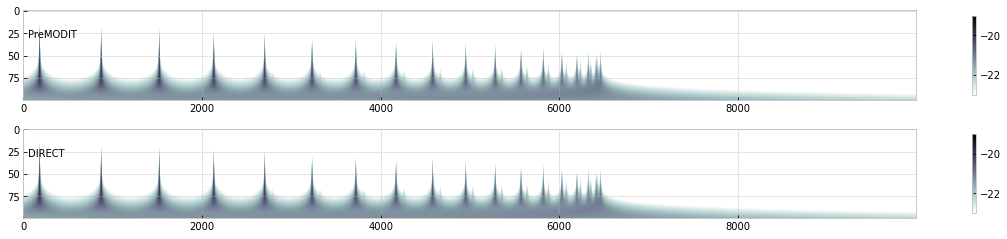

In [19]:
import numpy as np
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(20,4))
ax=fig.add_subplot(211)
c=plt.imshow(np.log10(xsm),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"PreMODIT")

ax.set_aspect(0.1/ax.get_data_ratio())
ax=fig.add_subplot(212)
c=plt.imshow(np.log10(xsmdirect),cmap="bone_r",vmin=-23,vmax=-19)
plt.colorbar(c,shrink=0.8)
plt.text(50,30,"DIRECT")
ax.set_aspect(0.1/ax.get_data_ratio())
plt.show()

In [21]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun
sourcef = planck.piBarr(Tarr,nus)
F0=rtrun(dtau,sourcef)


#also for LPF
dtaumdirect=dtauM(dParr,xsmdirect,MMR*np.ones_like(Tarr),molmassCO,g)
F0direct=rtrun(dtaumdirect,sourcef)

The difference is very small except around the edge (even for this it's only 1%).

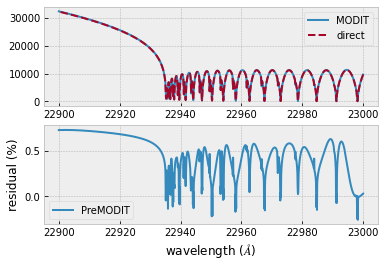

In [23]:
fig=plt.figure()
ax=fig.add_subplot(211)
plt.plot(wav[::-1],F0,label="MODIT")
plt.plot(wav[::-1],F0direct,ls="dashed",label="direct")
plt.legend()
ax=fig.add_subplot(212)
plt.plot(wav[::-1],(F0-F0direct)/np.median(F0direct)*100,label="PreMODIT")
plt.legend()
#plt.ylim(-0.1,0.1)
plt.ylabel("residual (%)")
plt.xlabel("wavelength ($\AA$)")
plt.show()

applying an instrumental response and planet/stellar rotation to the raw spectrum

In [25]:
from exojax.spec import response
from exojax.utils.constants import c
import jax.numpy as jnp

wavd=jnp.linspace(22920,23000,500) #observational wavelength grid
nusd = 1.e8/wavd[::-1]

RV=10.0 #RV km/s
vsini=20.0 #Vsini km/s
u1=0.0 #limb darkening u1
u2=0.0 #limb darkening u2

Rinst=100000.
beta=c/(2.0*np.sqrt(2.0*np.log(2.0))*Rinst) #IP sigma need check 

Frot=response.rigidrot(nus,F0,vsini,u1,u2)
F=response.ipgauss_sampling(nusd,nus,Frot,beta,RV)

(22920.0, 23000.0)

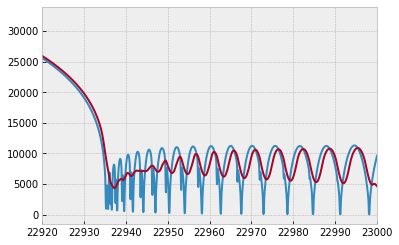

In [26]:
plt.plot(wav[::-1],F0)
plt.plot(wavd[::-1],F)
plt.xlim(22920,23000)